In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import tyssue
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt

from scipy import optimize

In [3]:
from tyssue.core import Epithelium

In [4]:
with pd.get_store('small_hexagonal.hf5') as store:
    cell_df = store.get('cell_df')
    jv_df = store.get('jv_df')
    je_df = store.get('je_df')


In [5]:
eptm = Epithelium('emin', cell_df, jv_df, je_df)

In [6]:
eptm.cell_df.head()

,perimeter,z,x,is_alive,area,y,old_idx
cell,,,,,,,
0,0.00000,-8.437398e+00,4.256965,0,12.000000,1.763293e+00,0
1,13.16405,-6.603181e+00,4.607705,1,12.396962,5.921189e-16,1
2,13.16405,-3.301591e+00,4.256965,1,12.396962,1.763293e+00,2
3,13.16405,-1.480297e-16,4.607705,1,12.396962,5.921189e-16,3
4,13.16405,3.301591e+00,4.256965,1,12.396962,1.763293e+00,4


we define the adimentional contractility $\bar\Gamma = \Gamma/K_vA_0h_0^2$ and line tension
$\bar\Lambda = \Lambda /K_v (A_0^{3/2}h_0^2)$, where $h_0$ is such that $V_0 = A_0h_0$.


In [7]:
parameters = {'contractility': 0.04,
              'line_tension': 0.12,
              'prefered_area':10.,
              'prefered_height':24.,
              'vol_elasticity':1.,
              'rho_lumen':4.}
with open('default_params.json', 'w') as param_json:
    json.dump(parameters, param_json)

def dimentionalize(parameters):
    dim_params = parameters.copy()
    Kv = parameters['vol_elasticity']
    A0 = parameters['prefered_area']
    h0 = parameters['prefered_height']
    
    dim_params['contractility'] = parameters['contractility'] * (Kv * A0 * h0**2)
    dim_params['line_tension'] = parameters['line_tension'] * (Kv * A0**1.5 * h0**2)
    dim_params['prefered_vol'] = A0 * h0
    return dim_params
adim_parameters = parameters.copy()
parameters = dimentionalize(parameters)



In [8]:
for key in ['vol_elasticity', 'prefered_area', 'prefered_vol',
            'prefered_height', 'contractility']:
    eptm.cell_df[key] = parameters[key]

eptm.je_df['line_tension'] = parameters['line_tension']


In [9]:
from tyssue.geometry import sheet_geometry

In [10]:
ncoords = ['nx', 'ny', 'nz']
for nc in ncoords:
    eptm.je_df[nc] = 0
sheet_geometry.update_all(eptm)

In [11]:
eptm.je_df.head()


,,,dy,dx,dz,length,old_jv0,old_jv1,old_cell,line_tension,nx,ny,nz,sub_area
srce,trgt,cell,,,,,,,,,,,,
1,0,0,-1.857558,0.369491,-1.10053,2.190482,56,57,0,2185.766319,1.888686,7.823193e-01,-6.863514e-01,1.078220e+00
2,1,0,-1.574762,1.052222,1.10053,2.190482,57,58,0,2185.766319,0.000000,-2.220446e-16,-3.330669e-16,2.001483e-16
0,1,1,1.857558,-0.369491,1.10053,2.190482,56,57,1,2185.766319,4.088597,5.421817e-01,4.575676e-01,2.074847e+00
3,0,1,1.857558,0.369491,-1.10053,2.190482,56,59,1,2185.766319,4.088597,-5.421817e-01,4.575676e-01,2.074847e+00
1,6,1,0.000000,0.000000,2.20106,2.201060,57,62,1,2185.766319,4.088597,2.710909e-01,0.000000e+00,2.048787e+00


In [12]:
def update_vol(eptm):
    eptm.cell_df['height'] = np.hypot(eptm.cell_df['y'],
                                      eptm.cell_df['x']) - parameters['rho_lumen']
    eptm.cell_df['vol'] = eptm.cell_df['height'] * eptm.cell_df['area']

update_vol(eptm)

def update_cylindrical(eptm):
    
    eptm.jv_df['rho'] = np.hypot(eptm.jv_df['y'],
                                 eptm.jv_df['x'])
    eptm.jv_df['theta'] = np.arctan2(eptm.jv_df['y'],
                                     eptm.jv_df['x'])
    eptm.cell_df['rho'] = np.hypot(eptm.cell_df['y'],
                                   eptm.cell_df['x'])
    eptm.cell_df['theta'] = np.arctan2(eptm.cell_df['y'],
                                       eptm.cell_df['x'])

update_cylindrical(eptm)
    
    
def compute_energy(eptm, full_output=False):
    live_cell_idx = (eptm.cell_df.is_alive==1).index
    live_cells = eptm.cell_df.loc[live_cell_idx]
    E_t = eptm.je_df['line_tension'] * eptm.je_df['length'] / 2
    E_v =  0.5 * (live_cells['vol_elasticity'] *
                  (live_cells['vol'] -
                   live_cells['prefered_vol'])**2
                  ) * live_cells['is_alive']
    E_c = 0.5 * (live_cells['contractility']
                 * live_cells['perimeter']**2
                 ) * live_cells['is_alive']
    if full_output:
        return E_t, E_c, E_v
    else:
        return E_t.sum() + (E_c+E_v).sum()

compute_energy(eptm, full_output=False)

2531418.9252106044

In [13]:
eptm.coords = ['x', 'y', 'z']

eptm.dcoords = ['dx', 'dy', 'dz']
eptm.normal_coords = ['nx', 'ny', 'nz']
eptm.cell_df['num_sides'] = np.bincount(eptm.e_cell_idx.get_level_values('cell'))

In [26]:
vol_elasticity0 = parameters['vol_elasticity']
prefered_area = parameters["prefered_area"]
height = parameters["prefered_height"]
prefered_vol = prefered_area * height
eptm.norm_factor = vol_elasticity0 * prefered_vol**2


def _to_3d(df):

    df_3d = np.asarray(df).repeat(3).reshape((df.size, 3))
    return df_3d

def compute_gradient(eptm, components=False):
    '''
    If components is True, returns the individual terms
    (grad_t, grad_c, grad_v)
    '''
    
    eptm.grad_i_lij = - (eptm.je_df[eptm.dcoords]
                         / _to_3d(eptm.je_df['length']))

    eptm.grad_i_lij.columns = eptm.coords
    grad_t = tension_grad(eptm)
    grad_c = contractile_grad(eptm)
    grad_v = volume_grad(eptm)

    grad_i = grad_t + grad_c + grad_v
    if components:
        return grad_i, grad_t, grad_c, grad_v
    return grad_i


def tension_grad(eptm):

    _grad_t = eptm.grad_i_lij * _to_3d(eptm.je_df['line_tension'])
    grad_t = _grad_t.sum(level='srce').loc[eptm.jv_idx]

    return grad_t


def contractile_grad(eptm):

    contract = eptm.cell_df['contractility']
    perimeter = eptm.cell_df['perimeter']

    gamma_L = contract * perimeter
    gamma_L = eptm.upcast_cell(gamma_L)

    _grad_c = eptm.grad_i_lij * _to_3d(gamma_L)
    grad_c = _grad_c.sum(level='srce').loc[eptm.jv_idx]

    return grad_c


def volume_grad(eptm):
    '''
    Computes :math:`\sum_\alpha\nabla_i \left(K (V_\alpha - V_0)^2\right)`
    '''

    elasticity = eptm.cell_df['vol_elasticity']
    pref_V = eptm.cell_df['prefered_vol']
    V = eptm.cell_df['vol']
    KV_V0 = elasticity * (V - pref_V) * eptm.cell_df['is_alive']
    tri_KV_V0 = eptm.upcast_cell(KV_V0)

    r_ijs = eptm.je_df[eptm.dcoords]
    cross_ur = pd.DataFrame(
        np.cross(eptm.je_df[eptm.normal_coords], r_ijs),
        index=eptm.je_idx, columns=eptm.coords)
        

    h_nu = eptm.cell_df['height'] / (2 * eptm.cell_df['num_sides'])

    grad_i_V_cell = cross_ur.groupby(level='cell').sum() * _to_3d(KV_V0 * h_nu)

    cell_term = eptm.upcast_cell(grad_i_V_cell)
    
    grad_v = cell_term.groupby(level='srce').sum()
    
    r_to_rho = eptm.jv_df[eptm.coords] / _to_3d(eptm.jv_df['rho'])
    r_to_rho = eptm.upcast_srce(df=r_to_rho)
    r_to_rho.columns = eptm.coords
    
    r_aj = (eptm.upcast_trgt(eptm.jv_df[eptm.coords]) -
            eptm.upcast_cell(eptm.cell_df[eptm.coords]))
    r_aj.columns = eptm.coords
    
    normals = eptm.je_df[eptm.normal_coords]
    cross_aj = pd.DataFrame(np.cross(r_aj, normals),
                            columns=eptm.coords, index=eptm.je_idx)

    tri_height = eptm.upcast_cell(eptm.cell_df['height'])

    sub_area = eptm.je_df['sub_area']

    ij_term = _to_3d(tri_KV_V0) * (_to_3d(sub_area / 2) * r_to_rho +
                                    _to_3d(tri_height / 2) * cross_aj)
    ij_term = pd.DataFrame(ij_term, index=eptm.je_idx, columns=eptm.coords)
    grad_v = grad_v + ij_term.groupby(level='srce').sum()
    grad_v = grad_v
    return grad_v.loc[eptm.jv_idx]


In [27]:
isotropic_relax(eptm)


In [28]:
def set_pos(pos, pos_idx, eptm, coords=['x', 'y', 'z']):
    
    pos = pos.reshape((pos.size//3, 3))
    eptm.jv_df.loc[pos_idx, eptm.coords] = pos

def opt_energy(pos, pos_idx, eptm):
    
    set_pos(pos, pos_idx, eptm)
    sheet_geometry.update_all(eptm)
    update_vol(eptm)
    return compute_energy(eptm, full_output=False)

def opt_grad(pos, pos_idx, eptm):
    grad_i = compute_gradient(eptm, components=False)
    return grad_i.values.flatten()

def approx_grad(eptm, coords=['x', 'y', 'z']):
    pos0 = eptm.jv_df[coords].values.flatten()
    pos_idx = eptm.jv_idx
    grad = optimize.approx_fprime(pos0,
                                  opt_energy,
                                  1e-9, pos_idx, eptm)
    return grad

    
def check_local_grad(eptm, coords=['x', 'y', 'z']):
    
    pos0 = eptm.jv_df[coords].values.flatten()
    pos_idx = eptm.jv_idx
    grad_err = optimize.check_grad(opt_energy,
                                   opt_grad,
                                   pos0.flatten(),
                                   pos_idx,
                                   eptm)
    return grad_err

In [29]:
#eptm.je_df['line_tension'] = parameters['line_tension']
#eptm.cell_df['contractility'] = parameters['contractility']
#eptm.cell_df['vol_elasticity'] = parameters['vol_elasticity']


grad_err = check_local_grad(eptm)
grad_err / eptm.norm_factor

0.27346212932567654

In [16]:
grad_i, grad_t, grad_c, grad_v = compute_gradient(eptm, components=True)

In [17]:
grad_i.head()

,x,y,z
jv,,,
0,1079.849283,-1465.909252,-3162.289858
1,873.994179,-1081.815587,90.235431
2,1800.123123,-272.985622,-3162.289858
3,-146.951926,-1382.966348,90.235431
4,609.433795,-264.705875,784.463679


In [22]:
mu = 6 * np.sqrt(2. / (3 * np.sqrt(3)))

def scale(eptm, delta):
    eptm.jv_df[eptm.coords] = eptm.jv_df[eptm.coords] * delta
    parameters['rho_lumen'] *= delta

def isotropic_energy(adim_parameters, delta):
    """
    Computes the theoritical energy per cell for the given
    parameters.
    """
    lbda = adim_parameters['line_tension']
    gamma = adim_parameters['contractility']

    elasticity = (delta**3 - 1 )**2 / 2.
    contractility = gamma * mu**2 * delta**2 / 2.
    tension = lbda * mu * delta / 2.
    energy = elasticity + contractility + tension
    return energy

def isotropic_grad_poly(adim_parameters):

    lbda = adim_parameters['line_tension']
    gamma = adim_parameters['contractility']
    grad_poly = [3, 0, 0,
                 -3,
                 mu**2 * gamma,
                 mu * lbda / 2.]
    return grad_poly

def isotropic_grad(adim_parameters, delta):
    grad_poly = isotropic_grad_poly(adim_parameters)
    return np.polyval(grad_poly, delta)

def find_grad_roots(adim_parameters):
    
    p = isotropic_grad_poly(adim_parameters)
    roots = np.roots(p)
    good_roots = np.real([r for r in roots if np.abs(r) == r])
    np.sort(good_roots)
    if len(good_roots) == 1:
        return good_roots
    elif len(good_roots) > 1:
        return good_roots[0]
    else:
        return np.nan

def isotropic_relax(eptm):

    update_cylindrical(eptm)
    area0 = parameters['prefered_area']
    h_0 = parameters['prefered_height']

    live_cell_idx = (eptm.cell_df.is_alive==1).index
    live_cells = eptm.cell_df.loc[live_cell_idx]
    
    area_avg = live_cells.area.mean()
    rho_avg = live_cells.rho.mean()


    ### Set height and area to height0 and area0
    delta = (area0 / area_avg)**0.5
    scale(eptm, delta)
    parameters['rho_lumen'] = rho_avg * delta - h_0
    sheet_geometry.update_all(eptm)
    update_vol(eptm)
    
    ### Optimal value for delta
    delta_o = find_grad_roots(adim_parameters)
    if not np.isfinite(delta_o):
        raise ValueError('invalid parameters values')
    eptm.delta_o = delta_o
    ### Scaling

    scale(eptm, delta_o)
    sheet_geometry.update_all(eptm)
    update_vol(eptm)



In [23]:
isotropic_relax(eptm)

In [24]:
grad_i, grad_t, grad_c, grad_v = compute_gradient(eptm, components=True)

In [25]:
grad_i.head() / eptm.norm_factor

AttributeError: 'Epithelium' object has no attribute 'norm_factor'

In [23]:
def elasticity(delta):
    return (delta**3 - 1 )**2 / 2.

def contractility(delta, gamma):
    return gamma * mu**2 * delta**2 / 2.

def tension(delta, lbda):
    return lbda * mu * delta / 2.

def isotropic_energy(delta, gamma, lbda):
    
    energy = (elasticity(delta)
              + contractility(delta, gamma)
              + tension(delta, lbda))
    return energy

In [24]:
live_cell_idx = (cell_df.is_alive==1).index

0.886592687387 0.783934586743


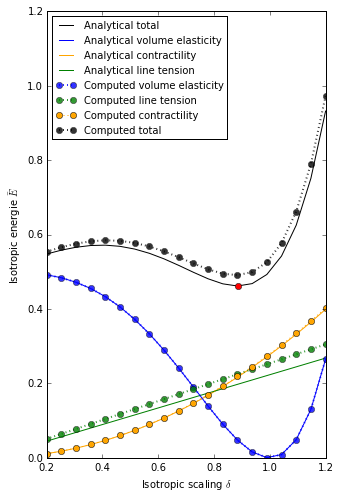

In [25]:
%matplotlib inline
deltas = np.linspace(0.2, 1.2, 20)
fig, ax = plt.subplots(figsize=(5, 8))
lbda = adim_parameters['line_tension']
gamma = adim_parameters['contractility']
ax.plot(deltas, isotropic_energy(deltas, gamma, lbda), 'k-',
        label='Analytical total')
ax.plot(eptm.delta_o, isotropic_energy(eptm.delta_o, gamma, lbda), 'ro')
ax.plot(deltas, elasticity(deltas), 'b-',
        label='Analytical volume elasticity')
ax.plot(deltas, contractility(deltas, gamma), color='orange', ls='-',
        label='Analytical contractility')
ax.plot(deltas, tension(deltas, lbda), 'g-',
        label='Analytical line tension')

ax.set_xlabel(r'Isotropic scaling $\delta$')
ax.set_ylabel(r'Isotropic energie $\bar E$')

update_cylindrical(eptm)

area0 = parameters['prefered_area']
h_0 = parameters['prefered_height']


### Cells only area and height
live_cells = eptm.cell_df[eptm.cell_df.is_alive==1]

area_avg = live_cells.area.mean()
rho_avg = live_cells.rho.mean()


### Set height and area to height0 and area0
delta = (area0 / area_avg)**0.5
scale(eptm, delta)
parameters['rho_lumen'] = rho_avg * delta - h_0
sheet_geometry.update_all(eptm)
update_vol(eptm)



energy = compute_energy(eptm)

norm = (parameters['prefered_area']**2 *
        parameters['prefered_height']**2 *
        parameters['vol_elasticity'] *
        eptm.cell_df.is_alive).sum()

energies = np.zeros((deltas.size, 3))
#scales = np.linspace(0.5, 1.2, 20) / eptm.delta_o
for n, delta in enumerate(deltas):
    scale(eptm, delta)
    sheet_geometry.update_all(eptm)
    update_vol(eptm)
    Et, Ec, Ev = compute_energy(eptm, full_output=True)
    energies[n, :] = [Et.sum(), Ec.sum(), Ev.sum()]
    scale(eptm, 1 / delta)
    sheet_geometry.update_all(eptm)
    update_vol(eptm)
    
isotropic_relax(eptm)


energies = np.array(energies) / norm
ax.plot(deltas, energies[:, 2], 'bo:', lw=2, alpha=0.8,
        label='Computed volume elasticity')
ax.plot(deltas, energies[:, 0], 'go:', lw=2, alpha=0.8,
        label='Computed line tension')
ax.plot(deltas, energies[:, 1], ls=':',
        marker='o', color='orange', label='Computed contractility')
ax.plot(deltas, energies.sum(axis=1), 'ko:', lw=2, alpha=0.8,
        label='Computed total')

ax.legend(loc='upper left', fontsize=10)
ax.set_ylim(0, 1.2)


print(eptm.delta_o, deltas[energies.sum(axis=1).argmin()] * eptm.delta_o)

In [26]:
eptm.delta_o

0.88659268738739017

In [27]:
edge_arrow_style = {'width':0.01,
                    'length_includes_head':True,
                    'shape':'right',
                    'color':'#2b5d0a',
                    'alpha':0.8,
                    'zorder':1}

points_style = {'s':100,
                'c':'#000a4b',
                'alpha':0.3,
                'zorder':2}

coords = ['x', 'y']

def plt_eptm(eptm, coords, edge_arrow_style, points_style):

    fig, ax = plt.subplots()
    try:
        dcoords = ['d'+c for c in coords]
        x, y = coords
        dx, dy = dcoords
    except (ValueError, TypeError):
        raise ValueError('The `coords` argument must be'
                         ' a pair of column names')
    
    ax.scatter(eptm.jv_df[x], eptm.jv_df[y], **points_style)

    for e in eptm.je_idx:
        s, t, c = e
        ax.arrow(eptm.jv_df[x].loc[s], eptm.jv_df[y].loc[s],
                 eptm.je_df[dx].loc[e], eptm.je_df[dy].loc[e],
                 **edge_arrow_style)

    ax.set_aspect('equal')
    ax.grid()
    return fig, ax
    
    

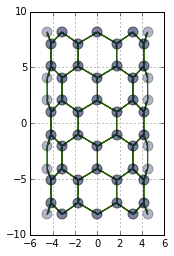

In [28]:
fig, ax = plt_eptm(eptm, ['x', 'z'], edge_arrow_style, points_style)

In [29]:
from scipy import optimize

In [54]:
app_grad = approx_grad(eptm, coords=['x', 'y', 'z'])

In [48]:
pos0 = eptm.jv_df[coords].values.flatten()
pos_idx = eptm.jv_idx

true_grad = opt_grad(pos0, pos_idx, eptm)

In [49]:
app_grad.shape

(288,)

In [50]:
true_grad.shape

(288,)

In [51]:
np.sqrt(np.sum(app_grad - true_grad)**2)

1303152.7862183899

245.13749484731821

In [ ]:
def plot_gradients(eptm)
    grad_i = compute_gradient(eptm, components=False)
    v_ixs = np.array([pos0[0::3], - grad_ixs]).T
    v_wys = np.array([pos0[1::3], - grad_wys]).T
    v_zeds = np.array([pos0[2::3], - grad_zeds]).T
    v_sigmas = np.array([sigmas, - grad_sigmas]).T

    if axes is None:
        ax_zs, ax_xy =  plot_2pannels(eptm, axes=None,
                                      **kwargs)
        axes = ax_zs, ax_xy
    else:
        ax_zs, ax_xy = axes
    x_lim = ax_zs.get_xlim()

    for s, z, x, y in zip(v_sigmas, v_zeds, v_ixs, v_wys):
        ax_xy.arrow(x[0], y[0], x[1], y[1], width=0.01,
                    ec=ec, fc=fc, alpha=0.5)
        ax_zs.arrow(z[0], s[0], z[1], s[1], width=0.01,
                    ec=ec, fc=fc, alpha=0.5)